In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline

In [2]:
data = pd.read_csv("Popularidad canciones.csv")

In [4]:
X = data.drop(columns=['Artista','Cancion','Genero','Popularidad'])
y = data["Popularidad"]

In [5]:
X.Tempo=(X.Tempo-np.mean(X.Tempo))/(np.std(X.Tempo))
X.Duracion_ms=(X.Loudness-np.mean(X.Duracion_ms))/(np.std(X.Duracion_ms))
X.Loudness=(X.Loudness-np.mean(X.Loudness))/(np.std(X.Loudness))

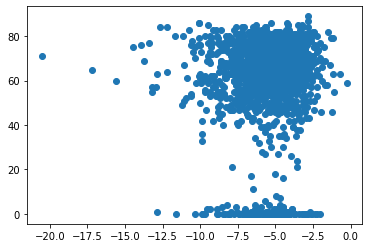

In [6]:
data.sort_values(by='Loudness', ascending=False)
plt.scatter(data['Loudness'],data['Popularidad'])

# STEP FUNCTION

In [7]:
#STEP FUNCTION
def split_in_bins(dataframe,bins):
    aux=dataframe.copy()
    aux['bin']=pd.cut(aux['Loudness'],bins)
    aux=pd.get_dummies(aux,columns=['bin'],drop_first=True)
    predictors=aux.iloc[:,-(bins-1):]
    target=aux['Popularidad']
    return predictors,target

In [8]:
errors=[]
for i in range(3,50):
    X3,y3=split_in_bins(data,i)
    linreg=LinearRegression()
    mean_accuracy=-cross_val_score(linreg, X3, y3, cv=10,scoring='neg_mean_absolute_error').mean()
    errors.append([i,mean_accuracy])

In [9]:
S = pd.DataFrame(errors,columns=['Bins','Error']).sort_values(by='Error').head()
num_bins = S.iloc[0]['Bins'].astype(np.int64)

In [10]:
#RESULTADOS
X3,y3=split_in_bins(data,num_bins)
linreg=LinearRegression().fit(X3,y3)
pd.DataFrame(index=['Constante']+list(X3.columns),data=[linreg.intercept_]+list(linreg.coef_),columns=['Coef'])

,Coef
Constante,68.000000
"bin_(-16.466, -12.419]",-6.727273
"bin_(-12.419, -8.371]",-10.462185
"bin_(-8.371, -4.324]",-9.396507
"bin_(-4.324, -0.276]",-5.392857


In [11]:
y_pred=linreg.predict(X3)
X_aux=pd.get_dummies(pd.cut(pd.DataFrame(list(range(np.round_(data.Loudness.min()).astype(np.int64),np.round_(data.Loudness.max()).astype(np.int64))),columns=['Loudness']).Loudness,num_bins),drop_first=True)

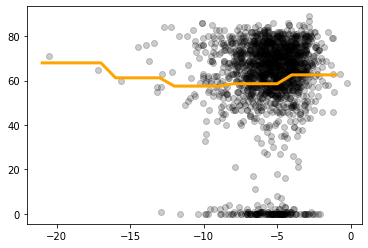

In [12]:
plt.scatter(data.Loudness,data.Popularidad,color='black',alpha=0.2)
plt.plot(list(range(np.round_(data.Loudness.min()).astype(np.int64),np.round_(data.Loudness.max()).astype(np.int64))),linreg.predict(X_aux),linewidth=3,color='orange')
plt.show()

# SPLINES

In [13]:
data.sort_values(by='Loudness',inplace=True)

In [14]:
def knot_list(df,predictor,n_knots):
    knots=[]
    for i in range(int(100/(n_knots+1)),int(100/(n_knots+1))*(n_knots+1),int(100/(n_knots+1))):
        corte=np.nanpercentile(df[predictor], i)
        knots.append(corte)
    return knots

In [15]:
def generar_X_spline(df,predictor,lista_knots, order):
    X_return=pd.DataFrame()
    for k in np.arange(1,order+1):
        X_return['x'+str(int(k))+'_']=df[predictor]**k
    for i in lista_knots:
        nombre_var='h(x,'+str(int(i))+')'
        X_return[nombre_var]=np.where(X_return['x1_']>i,(X_return['x1_']-i)**order,0)
    return X_return

In [16]:
errors=[]
for n in range(2,6):
    for n_knots in range(1,25):
        X6=generar_X_spline(data,'Loudness',knot_list(data,'Loudness',n_knots),n)
        y6=data['Popularidad']
        linreg=LinearRegression()
        mean_accuracy=-cross_val_score(linreg, X6, y6, cv=10,scoring='neg_mean_absolute_error').mean()
        errors.append([n,n_knots,mean_accuracy])

In [17]:
F = pd.DataFrame(errors,columns=['Order','Bins','Error']).sort_values(by='Error').head()
F

,Order,Bins,Error
0,2,1,15.370386
1,2,2,15.769445
24,3,1,15.813060
4,2,5,15.882051
15,2,16,16.286678


In [18]:
num_bins_splines = F.iloc[0]['Bins'].astype(np.int64)
num_order_splines = F.iloc[0]['Order'].astype(np.int64)
num_error_splines = F.iloc[0]['Error']
X7=generar_X_spline(data,'Loudness',knot_list(data,'Loudness',num_bins_splines),num_order_splines)
y7=data['Popularidad']
linreg=LinearRegression().fit(X7,y7)
pd.DataFrame(index=['Constante']+list(X7.columns),data=[linreg.intercept_]+list(linreg.coef_),columns=['Coef'])

,Coef
Constante,64.230279
x1_,1.432143
x2_,0.090133
"h(x,-5)",0.250483


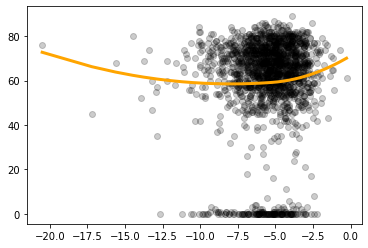

In [19]:
plt.scatter(X7.x1_,y,color='black',alpha=0.2)
plt.plot(X7.x1_,pd.DataFrame(linreg.predict(X7))[0],linewidth=3,color='orange')
plt.show()